In [11]:
#라이브러리 설치
import os
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

%matplotlib inline

import itertools

In [20]:
df = pd.read_csv('AirPassengers.csv')
df = df.rename(columns={'Month':'month','#Passengers':'passengers'})
df['month'] = pd.to_datetime(df['month'])
df = df.set_index('month')
df

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<AxesSubplot:xlabel='month'>

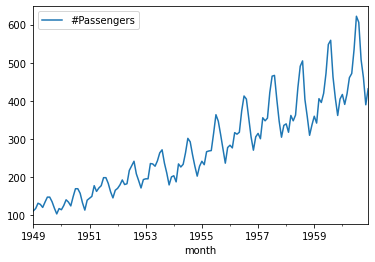

In [17]:
#데이터 전처리
#increasing seasonal임을 확인
fig = df.plot()
fig 

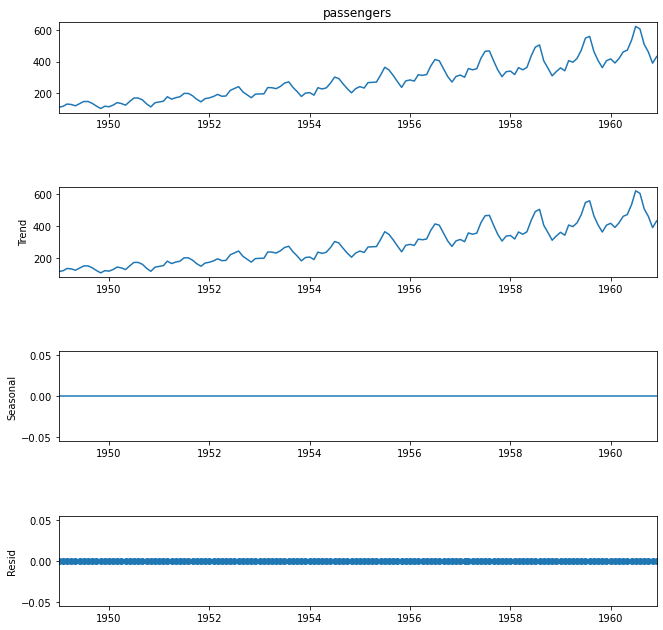

In [21]:
#시계열 분해
decompostion = sm.tsa.seasonal_decompose(df['passengers'], model='additive', period=1) #trend, seasonal, Resid를 확인하기 위한 작업
fig = decompostion.plot()
fig.set_size_inches(10,10)

In [22]:
#모델 구축
train, test = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)

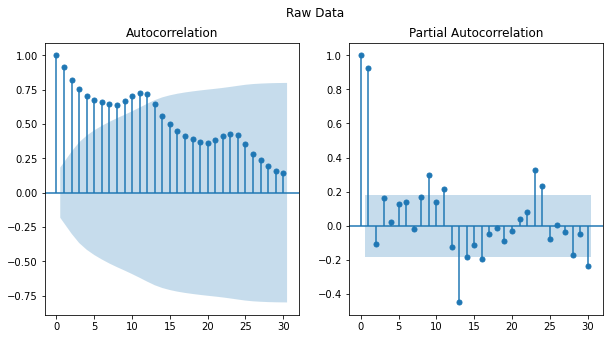

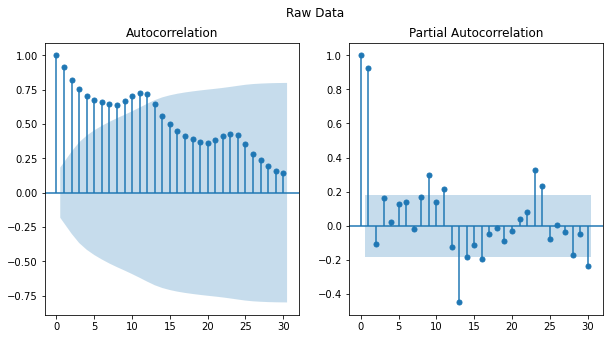

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1])

In [28]:
#Differencing - 차분
diff_train = train.copy()
diff_train = diff_train['passengers'].diff()
diff_train = diff_train.dropna() #결측치가 있으면 차분의 길이가 맞지 않아 제거
print('Raw Data')
print(train)
print('Differencing Data')
print(diff_train)

Raw Data
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
Differencing Data
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


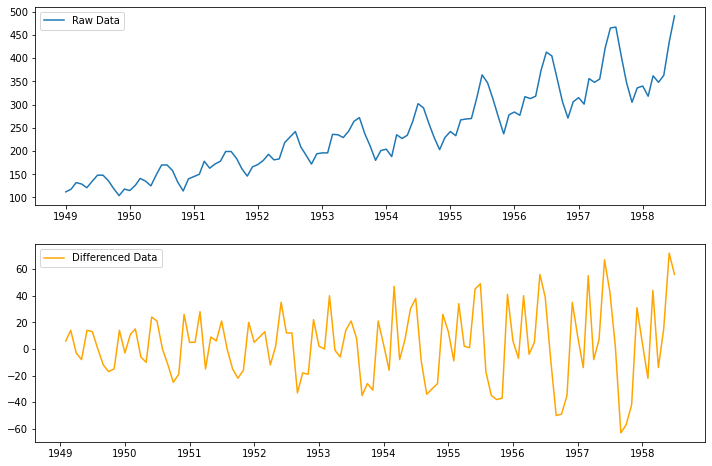

In [33]:
#차분 시각화
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train['passengers'])
plt.legend(['Raw Data'])
plt.subplot(212)
plt.plot(diff_train,'orange')
plt.legend(['Differenced Data'])

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


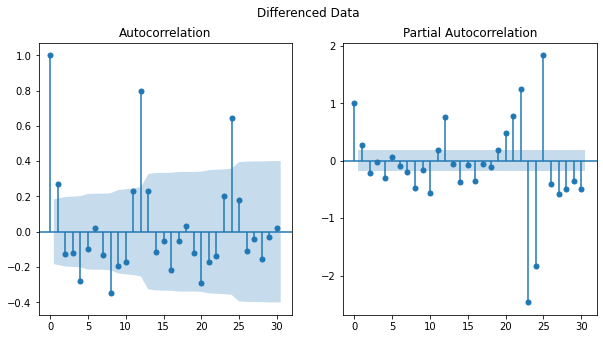

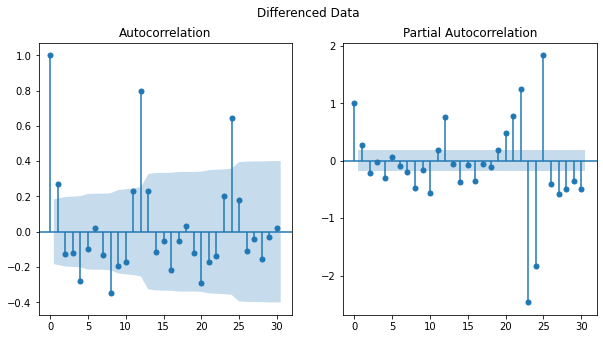

In [35]:
#ACF, PACF 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train.values.squeeze(), lags=30, ax=ax[1])

In [36]:
#ACF가 sin함수 형태를 띄우므로 AR 모형 선택
model = ARIMA(train.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Tue, 25 May 2021   AIC                           1069.440
Time:                        21:21:10   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5123      3.329      1.055      0.291      -3.012      10.037
ar.L1.D.y      0.2803      0.091      3.077      0.002       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
#최적 파라미터 구하기
import warnings
warnings.filterwarnings(action='ignore')

print('Examples of parameter combinations for Seasonal ARIMA')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))

aic = []
for i in pdq:
    model = ARIMA(train.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >>AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

Examples of parameter combinations for Seasonal ARIMA
ARIMA: (0, 1, 0) >>AIC : 1076.52
ARIMA: (0, 1, 1) >>AIC : 1064.62
ARIMA: (0, 1, 2) >>AIC : 1061.08
ARIMA: (1, 1, 0) >>AIC : 1069.44
ARIMA: (1, 1, 1) >>AIC : 1058.83
ARIMA: (1, 1, 2) >>AIC : 1046.05
ARIMA: (2, 1, 0) >>AIC : 1066.2
ARIMA: (2, 1, 1) >>AIC : 1045.66
ARIMA: (2, 1, 2) >>AIC : 1047.19


In [40]:
#최적 파라미터 찾기

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1045.66)]

In [41]:
#모델링 (최적 파라미터 이용)
model_opt = ARIMA(train.values, order=(2,1,1))
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.316
Date:                Tue, 25 May 2021   AIC                           1045.660
Time:                        21:30:18   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.162     15.754      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4540           -0.1046
AR.2            1.1512           +0.8882j            1.4540            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [43]:
#예측
pred = model_opt_fit.forecast(len(test))
pred_value = pred[0]
pred_ub = pred[2][:,0]
pred_lb = pred[2][:,1]
pred_idx = list(test.index)
r2 = r2_score(test, pred_value)

Text(0.5, 0.98, 'ARIMA (2, 1, 1) Prediction Result (r2_score : 0.22)')

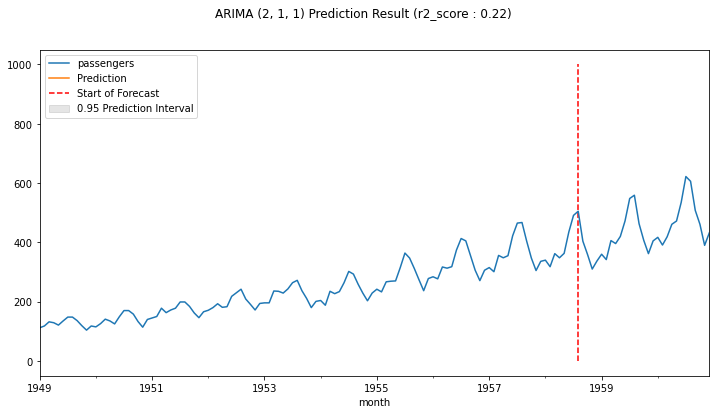

In [58]:
#예측 시각화 
#빨간선 기준 오른쪽(train), 왼쪽(test)
#test 영역 주황선(예측값), 파란선(실제값), 회색선(interval 값)
fig, ax = plt.subplots(figsize=(12,6))
df.plot(ax=ax)
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(pred_idx, pred_value, label='Prediction')
ax.fill_between(pred_idx, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Result (r2_score : {round(r2,2)})')